# Audio Model Assembly


In [65]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Sound Data Preprocessing

The first thing that we can do is trim the silence at the beginning and end of our audio snippet

In [80]:
def trim_audio_data(audio_data):
    trimmed, _ = librosa.effects.trim(audio_data, top_db=10)
    return trimmed

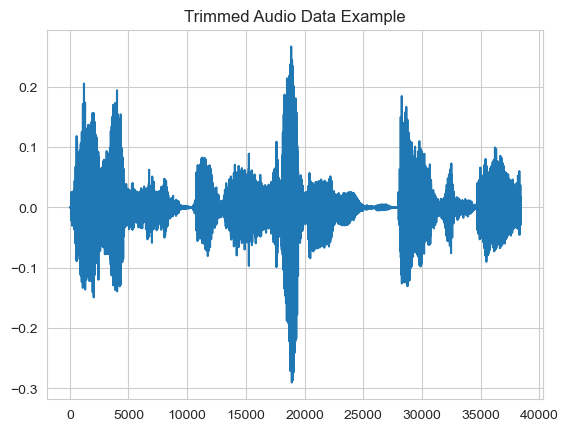

In [81]:
example = trim_audio_data(y_data[0])
plt.plot(example)
plt.lw = 1
plt.title("Trimmed Audio Data Example")
plt.show()

Next we can take a look at a spectrogram to see what frequencies occur at what points in our data

In [82]:
def spectrogram(audio_data):
    D = librosa.stft(audio_data)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_db

In [83]:
example = spectrogram(example)
example.shape

(1025, 76)

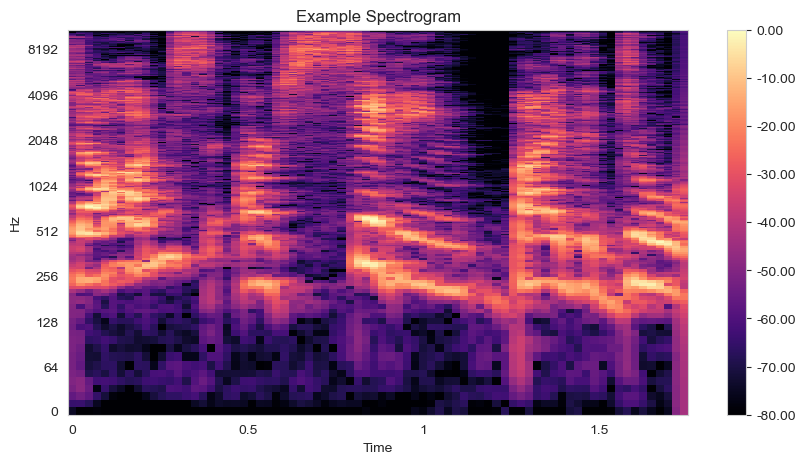

In [84]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(example, x_axis='time', y_axis='log', ax=ax)
ax.set(title="Example Spectrogram")
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

From there we can look at the mel spectrogram 

In [85]:
def mel_spectrogram(audio_data, sampling_rate):
    ms = librosa.feature.melspectrogram(y=audio_data, sr=sampling_rate, n_mels=128)
    ms = librosa.amplitude_to_db(ms, ref=np.max) 
    return ms

In [86]:
example2 = mel_spectrogram(y_data[0], sr_data[0])
example2.shape

(128, 169)

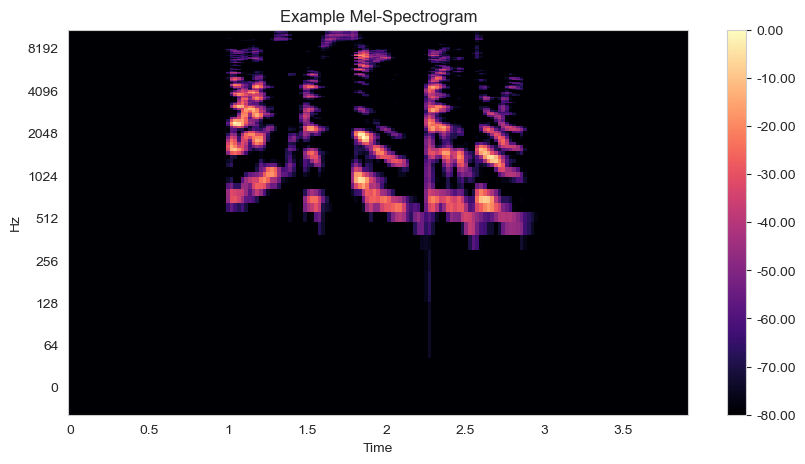

In [87]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(example2, x_axis='time', y_axis='log', ax=ax)
ax.set(title="Example Mel-Spectrogram")
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

This mel spectrogram data is what we need to pass into our audio model. 

We can now build a full function to preprocess all of our audio data


In [88]:
import numpy as np
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, spectrograms, labels, max_width):
        """
        spectrograms: A list of arrays, each representing a spectrogram.
        categorical_data: A list where each element can be a number or a numpy array representing categorical data.
        labels: A list of labels.
        max_width: The maximum width to pad the spectrograms to.
        """
        self.spectrograms = spectrograms
        self.labels = labels
        self.max_width = max_width

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Retrieve the spectrogram and pad it to the maximum width
        spectrogram = self.spectrograms[idx]
        current_width = spectrogram.shape[1]
        padding_width = self.max_width - current_width
        if padding_width > 0:
            # Pad the spectrogram with zeros on the right side
            spectrogram = np.pad(spectrogram, ((0, 0), (0, padding_width)), mode='constant', constant_values=0)

        # Convert the spectrogram to a torch tensor
        spectrogram_tensor = torch.tensor(spectrogram).float()
        if spectrogram_tensor.dim() == 2:
            spectrogram_tensor = spectrogram_tensor.unsqueeze(0)

        # Convert the label to a torch tensor
        label_tensor = torch.tensor(self.labels[idx]).float()

        return spectrogram_tensor, label_tensor


In [89]:
from sklearn.model_selection import train_test_split

def audio_preprocess():
    # drop the channel feature
    # drop sample rate feature
    audio_data_processed = data.copy()
    audio_data_processed = audio_data_processed.drop(columns=['channel', 'sample rate'])
    
    # convert raw audio clip to mel spectrogram
    SAMPLE_RATE = 22050
    for index, row in audio_data_processed.iterrows():
        audio_data_processed.at[index, "audio data"] = mel_spectrogram(audio_data_processed.at[index, "audio data"], SAMPLE_RATE)

    # run one hot encoding on categorical variables and reshape
    audio_data_processed = pd.get_dummies(audio_data_processed, columns=['intensity', 'sentence', 'emotion'], )

    audio_data_processed['cat_data'] = audio_data_processed.apply(lambda row: [row['intensity_normal'], 
                                                                               row['intensity_strong'], 
                                                                               row['sentence_Dogs are sitting by the door.'],
                                                                               row['sentence_Kids are talking by the door.']], axis=1)

    audio_data_processed['labels'] = audio_data_processed.apply(lambda row: [row['emotion_angry'],
                                                                               row['emotion_calm'],
                                                                               row['emotion_disgust'],
                                                                               row['emotion_fearful'],
                                                                               row['emotion_happy'],
                                                                               row['emotion_neutral'],
                                                                               row['emotion_sad'],
                                                                               row['emotion_surprised'],], axis=1)
    
    audio_data_processed.rename(columns={'emotion': 'labels', 'audio data': 'spectrogram_data'}, inplace=True)
    audio_data_processed.drop(columns=['intensity_normal', 
                                       'intensity_strong', 
                                       'sentence_Dogs are sitting by the door.', 
                                       'sentence_Kids are talking by the door.',
                                       'emotion_angry',
                                       'emotion_calm',
                                       'emotion_disgust',
                                       'emotion_fearful',
                                       'emotion_happy',
                                       'emotion_neutral',
                                       'emotion_sad',
                                       'emotion_surprised'], inplace=True)
    
    

    X = audio_data_processed['spectrogram_data']
    y = audio_data_processed['labels']
    y = y.apply(lambda x: np.array(x, dtype=np.float32))

    # Split the data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = audio_preprocess()
print(X_train)

1066    [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
674     [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
200     [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
961     [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
746     [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
                              ...                        
678     [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
1390    [[-80.0, -78.43902, -78.6445, -80.0, -80.0, -7...
1053    [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
316     [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
789     [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
Name: spectrogram_data, Length: 1008, dtype: object


In [90]:
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Convert parts of the DataFrame into the appropriate format
spectrograms_train = list(X_train)
labels_train = y_train.tolist()

spectrograms_test = list(X_test)
labels_test = y_test.tolist()

# Create Dataset
max_width = max(max(s.shape[1] for s in spectrograms_train), max(s.shape[1] for s in spectrograms_test))
train_dataset = MyDataset(spectrograms_train, labels_train, max_width)
test_dataset = MyDataset(spectrograms_test, labels_test, max_width)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Audio Model

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [92]:
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 5))

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Adjust the input size accordingly
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 8)


    def forward(self, spec_data):
        x = self.pool(F.relu(self.conv1(spec_data)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = self.adaptive_pool(x)

        # Flatten the output for the dense layers
        x = x.view(-1, 64 * 5 * 5)

        # Pass the flattened output through dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming 'train_loader' is your DataLoader for training data
# Initialize the model
model = AudioCNN().to(device)
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer (adjust learning rate as needed)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 200

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for spectrograms, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Optional: Save the model checkpoint
torch.save(model.state_dict(), 'audio_model_path.pth')

Epoch 1/200, Loss: 2.0611
Epoch 2/200, Loss: 2.0185
Epoch 3/200, Loss: 1.9875
Epoch 4/200, Loss: 1.9792
Epoch 5/200, Loss: 1.9680
Epoch 6/200, Loss: 1.9633
Epoch 7/200, Loss: 1.9588
Epoch 8/200, Loss: 1.9494
Epoch 9/200, Loss: 1.9526
Epoch 10/200, Loss: 1.9469
Epoch 11/200, Loss: 1.9439
Epoch 12/200, Loss: 1.9371
Epoch 13/200, Loss: 1.9404
Epoch 14/200, Loss: 1.9340
Epoch 15/200, Loss: 1.9354
Epoch 16/200, Loss: 1.9258
Epoch 17/200, Loss: 1.9215
Epoch 18/200, Loss: 1.9090
Epoch 19/200, Loss: 1.8996
Epoch 20/200, Loss: 1.8792
Epoch 21/200, Loss: 1.8457
Epoch 22/200, Loss: 1.8133
Epoch 23/200, Loss: 1.7836
Epoch 24/200, Loss: 1.7490
Epoch 25/200, Loss: 1.7308
Epoch 26/200, Loss: 1.7277
Epoch 27/200, Loss: 1.7013
Epoch 28/200, Loss: 1.7042
Epoch 29/200, Loss: 1.7026
Epoch 30/200, Loss: 1.6680
Epoch 31/200, Loss: 1.6619
Epoch 32/200, Loss: 1.6541
Epoch 33/200, Loss: 1.6429
Epoch 34/200, Loss: 1.6220
Epoch 35/200, Loss: 1.6170
Epoch 36/200, Loss: 1.6086
Epoch 37/200, Loss: 1.5966
Epoch 38/2

## Evaluation Metrics

checking accuracy

In [114]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(8)]
    n_class_samples = [0 for i in range(8)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        labels = torch.argmax(labels, dim=1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(4):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    classes = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprise']
    for i in range(8):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 59.02777777777778 %
Accuracy of angry: 58.92857142857143 %
Accuracy of calm: 72.72727272727273 %
Accuracy of disgust: 75.0 %
Accuracy of fearful: 47.45762711864407 %
Accuracy of happy: 47.45762711864407 %
Accuracy of neutral: 45.16129032258065 %
Accuracy of sad: 43.10344827586207 %
Accuracy of surprise: 77.58620689655173 %


In [115]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from scipy.special import softmax

# Assume classes are as defined
classes = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprise']

# Variables to collect predictions and labels
all_labels = []
all_predictions = []
all_probabilities = [] # For ROC

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        labels = torch.argmax(labels, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(softmax(outputs.cpu().numpy(), axis=1))

# Convert lists to arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# F1 Score
f1 = f1_score(all_labels, all_predictions, average='macro')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# ROC and AUC - Note: This approach is for binary classification or OvR (One vs Rest) in multi-class
all_labels_bin = label_binarize(all_labels, classes=list(range(len(classes))))
roc_auc = roc_auc_score(all_labels_bin, all_probabilities, multi_class='ovr')

Confusion matrix, without normalization


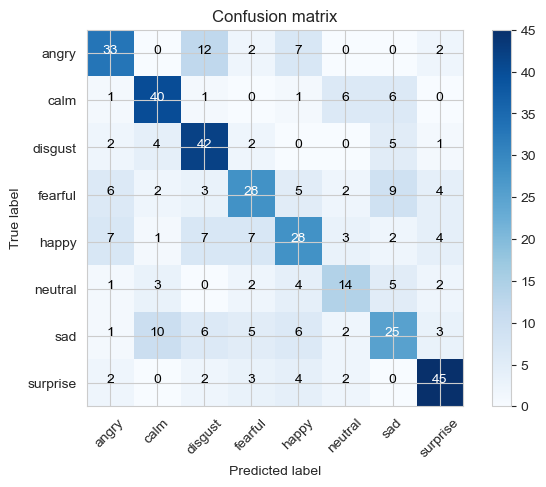

In [116]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Assuming cm is the confusion matrix you computed and classes is your list of class names
plot_confusion_matrix(cm, classes)

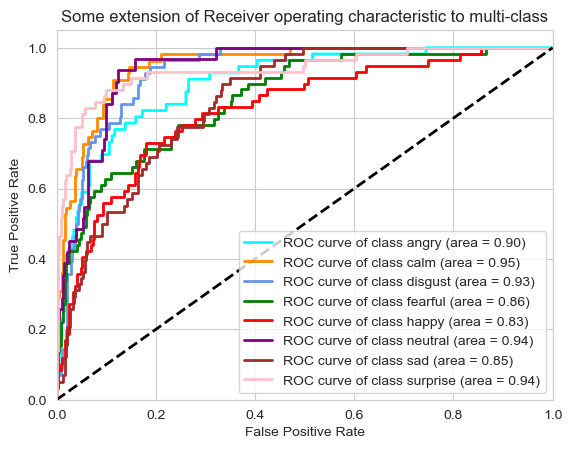

In [117]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_curve(y_test, y_score, n_classes, classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

# Assuming y_test is your true binary labels and y_score is the probabilities
# n_classes is the number of classes and classes is a list of class names
plot_roc_curve(all_labels_bin, all_probabilities, len(classes), classes)

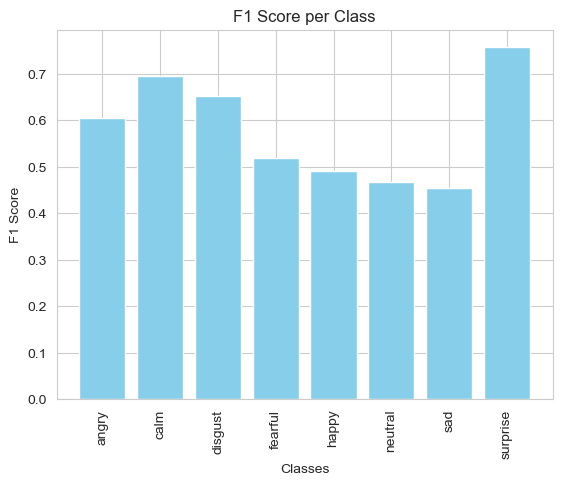

In [118]:
from sklearn.metrics import f1_score

def plot_f1_scores(y_true, y_pred, classes):
    # Calculate F1 scores for each class
    f1_scores = f1_score(y_true, y_pred, average=None)

    # Plot
    plt.bar(range(len(classes)), f1_scores, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('F1 Score')
    plt.xticks(ticks=range(len(classes)), labels=classes, rotation='vertical')
    plt.title('F1 Score per Class')
    plt.show()

# Assuming y_true and y_pred are your true and predicted labels respectively
# and classes is a list of your class names
plot_f1_scores(all_labels, all_predictions, classes)

# Demo

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# working with audio data
import librosa
import librosa.display

# playing audio in notebook
import IPython.display as ipd

In [ ]:
file_path = "User/split_input/audio.wav"

#features
channel_data = []
emotion_data = []
intensity_data = []
sentence_data = []
y_data = []
sr_data = []


# filename of individual wav file
paths.append(file_path)

y, sr = librosa.load(file_path)

In [ ]:
plt.plot(y)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

def test_preprocess(y, sr):
    # convert raw audio clip to mel spectrogram
    y = mel_spectrogram(y, sr)
    y = torch.tensor(y)
    y = y.unsqueeze(0)  
    return y
    

test_data = test_preprocess(y, sr)

In [ ]:
model = AudioCNN()
model.load_state_dict(torch.load('model_path.pth'))

In [ ]:
with torch.no_grad():
    prediction = model(torch.tensor(test_data))
    prediction = torch.softmax(prediction, dim=1)


labels = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprise']
for i in range(len(labels)):
    print(labels[i], ": ", prediction[0][i])